In [0]:
%cd "/content/drive/My Drive/Uni Stuff/DSinLS/Task7"

/content/drive/My Drive/Uni Stuff/DSinLS/Task7


In [0]:
%matplotlib inline

import glob
from platform import python_version

import matplotlib
import numpy as np
import pandas as pd
import sklearn
import torch
import matplotlib.pyplot as plt

plt.rcParams[
    "figure.facecolor"
] = "w"

In [0]:
def generate_sequence(scaler, model, x_sample, future=100):
    """ Generate future values for x_sample with the model """
    y_pred_tensor = model(x_sample, future=future)
    y_pred = y_pred_tensor.cpu().tolist()
    y_pred = scaler.inverse_transform(y_pred)
    return y_pred

def to_dataframe(actual, predicted):
    return pd.DataFrame({"actual": actual, "predicted": predicted})


def inverse_transform(scalar, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df
    

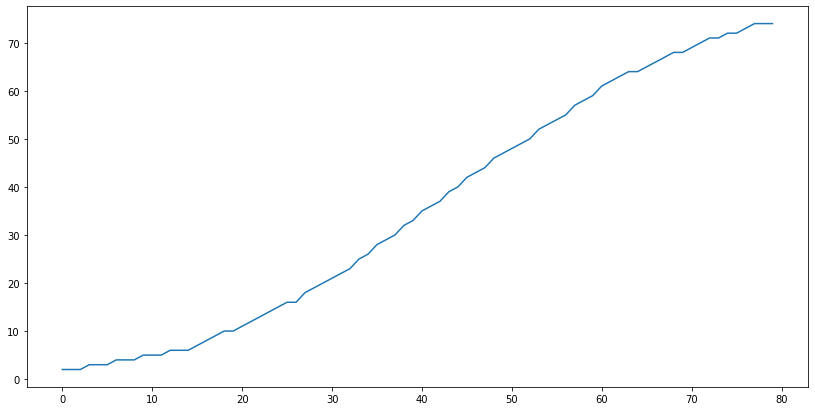

In [0]:
df = pd.read_csv('./Data/ABM_data.csv',delimiter=';')

df.set_index('day')
df_grouped=df.groupby(['day'] ,  group_keys=False ).apply(
    lambda row: row.confirmed_cases
)

ax=df_grouped.plot(figsize=(14, 7))

In [0]:
df_train = df_grouped[df_grouped.index < 60].to_frame(name="confirmed_cases")
df_val = df_grouped[df_grouped.index >= 60].to_frame(name="confirmed_cases")

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_arr = scaler.fit_transform(df_train)
val_arr = scaler.transform(df_val)

In [0]:
def transform_data(arr, seq_len):
    x, y = [], []
    for i in range(len(arr) - seq_len):
        x_i = arr[i : i + seq_len]
        y_i = arr[i + 1 : i + seq_len + 1]
        x.append(x_i)
        y.append(y_i)
    x_arr = np.array(x).reshape(-1, seq_len)
    y_arr = np.array(y).reshape(-1, seq_len)
    x_var = Variable(torch.from_numpy(x_arr).float())
    y_var = Variable(torch.from_numpy(y_arr).float())
    return x_var, y_var

from torch.autograd import Variable

seq_len = 10

x_train, y_train = transform_data(train_arr, seq_len)
x_val, y_val = transform_data(val_arr, seq_len)

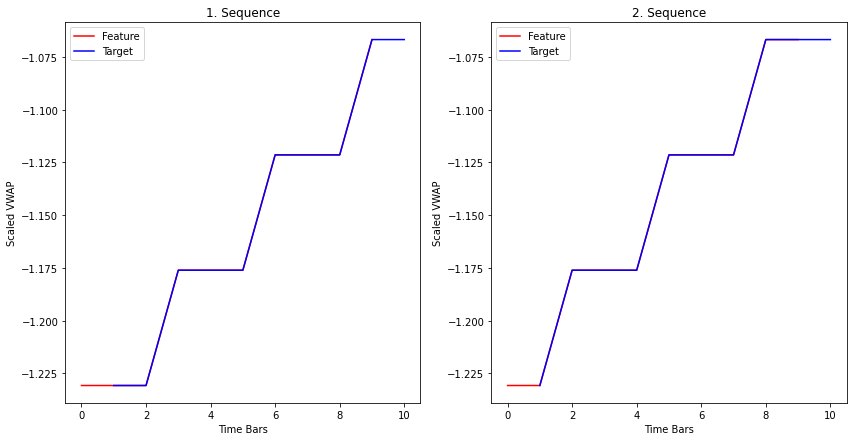

In [0]:
def plot_sequence(axes, i, x_train, y_train):
    axes[i].set_title("%d. Sequence" % (i + 1))
    axes[i].set_xlabel("Time Bars")
    axes[i].set_ylabel("Scaled VWAP")
    axes[i].plot(range(seq_len), x_train[i].cpu().numpy(), color="r", label="Feature")
    axes[i].plot(range(1, seq_len + 1), y_train[i].cpu().numpy(), color="b", label="Target")
    axes[i].legend()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
plot_sequence(axes, 0, x_train, y_train)
plot_sequence(axes, 1, x_train, y_train)

In [0]:
from LSTM import *
model_1 = Model(input_size=1, hidden_size=21, output_size=1)
loss_fn_1 = nn.MSELoss()
optimizer_1 = optim.Adam(model_1.parameters(), lr=0.01)
scheduler_1 = optim.lr_scheduler.StepLR(optimizer_1, step_size=5, gamma=0.1)
optimization_1 = Optimization(model_1, loss_fn_1, optimizer_1, scheduler_1)
optimization_1.train(x_train, y_train, x_val, y_val,batch_size=1,n_epochs=20, do_teacher_forcing=True)

Epoch 1 Train loss: 0.23. Validation loss: 0.86. Avg future: 2.86. Elapsed time: 0.43s.
Epoch 2 Train loss: 1.31. Validation loss: 3.08. Avg future: 2.67. Elapsed time: 0.19s.
Epoch 3 Train loss: 0.30. Validation loss: 0.81. Avg future: 2.86. Elapsed time: 0.19s.
Epoch 4 Train loss: 0.31. Validation loss: 1.02. Avg future: 3.14. Elapsed time: 0.18s.
Epoch 5 Train loss: 0.13. Validation loss: 0.93. Avg future: 2.67. Elapsed time: 0.18s.
Epoch 6 Train loss: 0.13. Validation loss: 0.80. Avg future: 2.96. Elapsed time: 0.19s.
Epoch 7 Train loss: 0.10. Validation loss: 0.77. Avg future: 3.35. Elapsed time: 0.19s.
Epoch 8 Train loss: 0.07. Validation loss: 0.80. Avg future: 2.61. Elapsed time: 0.18s.
Epoch 9 Train loss: 0.06. Validation loss: 0.85. Avg future: 2.73. Elapsed time: 0.19s.
Epoch 10 Train loss: 0.04. Validation loss: 0.89. Avg future: 3.10. Elapsed time: 0.19s.
Epoch 11 Train loss: 0.03. Validation loss: 0.89. Avg future: 2.59. Elapsed time: 0.19s.
Epoch 12 Train loss: 0.03. Val

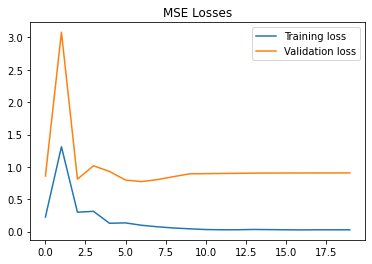

In [0]:
optimization_1.plot_losses()

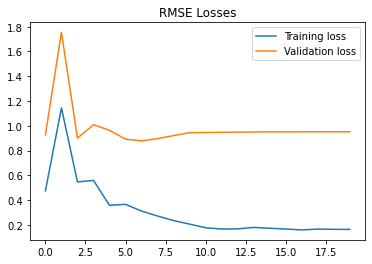

In [0]:
optimization_1.plot_RMSElosses()

Test loss 1.0331


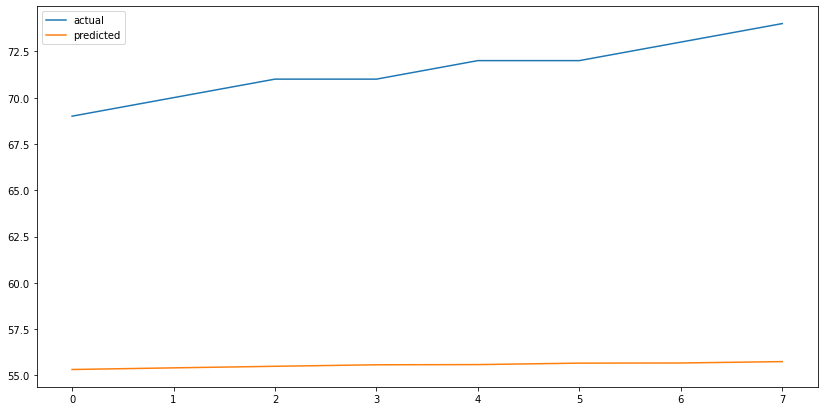

In [0]:
actual_1, predicted_1, test_loss_1 = optimization_1.evaluate(x_val, y_val, future=0, batch_size=2)
df_result_1 = to_dataframe(actual_1, predicted_1) 
df_result_1 = inverse_transform(scaler, df_result_1, ['actual', 'predicted'])
df_result_1.plot(figsize=(14, 7))
print("Test loss %.4f" % test_loss_1)